In [ ]:
import pickle
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# ─── Load Data ───────────────────────────────────────────────────────────────
dataset_path_dict = {
    "embeddings": "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl",
    "neural": "/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy"
}

with open(dataset_path_dict['embeddings'], "rb") as f:
    embeddings_raw = pickle.load(f)
embeddings = embeddings_raw['natural_scenes']  # shape: (118, 1000)

neural_data = np.load(dataset_path_dict["neural"])  # shape: (39209, 5900)

# ─── Construct Trial-wise Design Matrix ──────────────────────────────────────
n_images = embeddings.shape[0]        # 118
n_trials = 50
n_total = n_images * n_trials         # 5900

X_all = np.repeat(embeddings, n_trials, axis=0)  # shape: (5900, 1000)
y_all = neural_data[226]                         # Neuron 226 binary spikes, shape: (5900,)
#226,593
# ─── 10-Fold Cross Validation ────────────────────────────────────────────────
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores = []

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_all)):
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    try:
        model = LogisticRegression(solver="liblinear", max_iter=1000)
        model.fit(X_train, y_train)
        probs_pred = model.predict_proba(X_test)[:, 1]
        r2 = r2_score(y_test, probs_pred)
        r2_scores.append(r2)
        print(f"Fold {fold_idx+1}: R² = {r2:.4f}", flush=True)
    except Exception as e:
        print(f"Fold {fold_idx+1} error: {e}", flush=True)
        r2_scores.append(None)

# ─── Final Result ────────────────────────────────────────────────────────────
r2_scores_clean = [r for r in r2_scores if r is not None]
avg_r2 = np.mean(r2_scores_clean)
print(f"\nAverage R² for neuron 226 across {len(r2_scores_clean)} folds: {avg_r2:.4f}", flush=True)


Fold 1: R² = 0.1812
Fold 2: R² = 0.1166
Fold 3: R² = 0.1619
Fold 4: R² = 0.1942
Fold 5: R² = 0.2001
Fold 6: R² = 0.1665
Fold 7: R² = 0.1562
Fold 8: R² = 0.1782
Fold 9: R² = 0.2037
Fold 10: R² = 0.1842

Average R² for neuron 226 across 10 folds: 0.1743


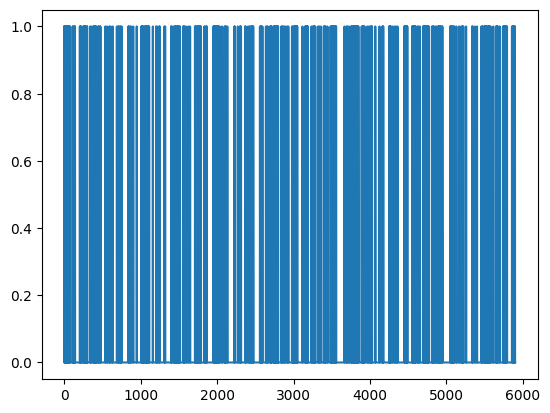

In [5]:
import matplotlib.pyplot as plt

plt.plot(y_all)

In [9]:
y_all.nonzero()[0].shape


(580,)

In [10]:
metadata=np.load('/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/cell_specimen_ids_in_order.npy')

In [15]:
metadata[226]
metadata[593]

np.int64(517471803)

Neuron 226 fit complete. Nonzero weights: 1000
Neuron 593 fit complete. Nonzero weights: 1000


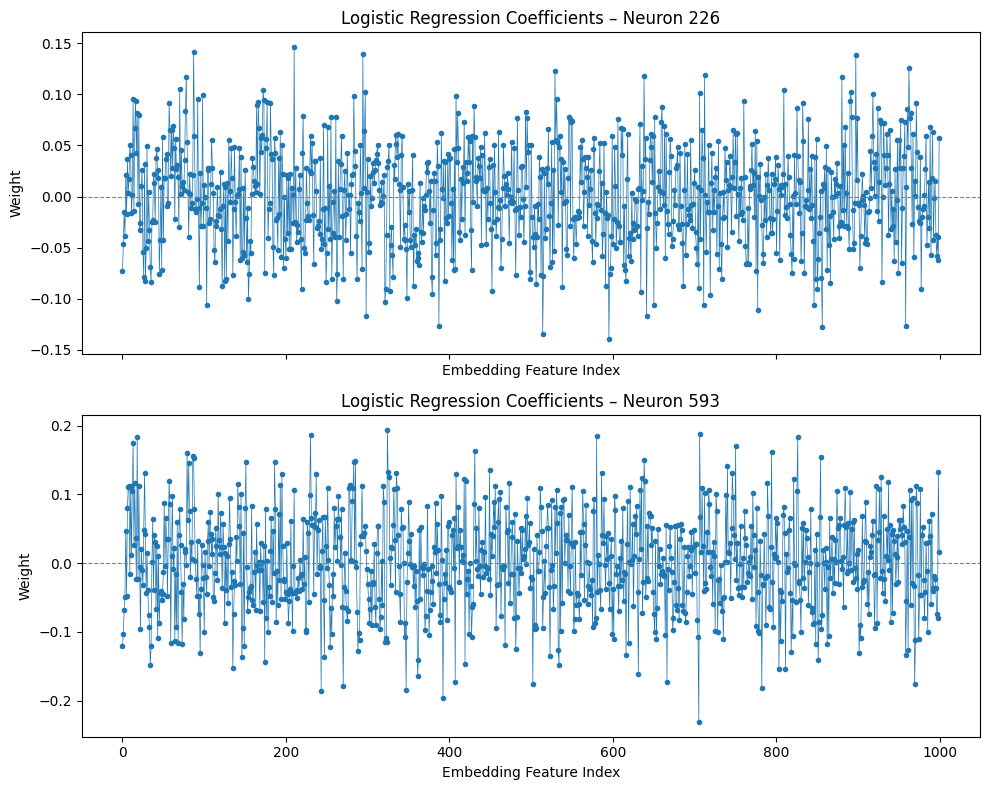

In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# ─── Load Data ───────────────────────────────────────────────────────────────
dataset_path_dict = {
    "embeddings": "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl",
    "neural": "/home/maria/LuckyMouse2/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy"
}

with open(dataset_path_dict['embeddings'], "rb") as f:
    embeddings_raw = pickle.load(f)
embeddings = embeddings_raw['natural_scenes']  # shape: (118, 1000)

neural_data = np.load(dataset_path_dict["neural"])  # shape: (39209, 5900)

# ─── Construct Trial-wise Design Matrix ──────────────────────────────────────
n_images = embeddings.shape[0]
n_trials = 50
X_all = np.repeat(embeddings, n_trials, axis=0)  # shape: (5900, 1000)

# ─── Neurons to Analyze ──────────────────────────────────────────────────────
selected_neurons = [226, 593]
coeffs = {}

# ─── Fit Model and Store Coefficients ────────────────────────────────────────
for neuron_idx in selected_neurons:
    y_all = neural_data[neuron_idx]
    model = LogisticRegression(solver="liblinear", max_iter=1000)
    model.fit(X_all, y_all)
    coeffs[neuron_idx] = model.coef_.flatten()
    print(f"Neuron {neuron_idx} fit complete. Nonzero weights: {(coeffs[neuron_idx] != 0).sum()}")

# ─── Plot Coefficients ───────────────────────────────────────────────────────
fig, axs = plt.subplots(len(selected_neurons), 1, figsize=(10, 4 * len(selected_neurons)), sharex=True)

if len(selected_neurons) == 1:
    axs = [axs]  # ensure iterable

for ax, neuron_idx in zip(axs, selected_neurons):
    w = coeffs[neuron_idx]
    ax.plot(w, marker='.', linestyle='-', linewidth=0.5)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_title(f"Logistic Regression Coefficients – Neuron {neuron_idx}")
    ax.set_ylabel("Weight")
    ax.set_xlabel("Embedding Feature Index")

plt.tight_layout()
plt.show()


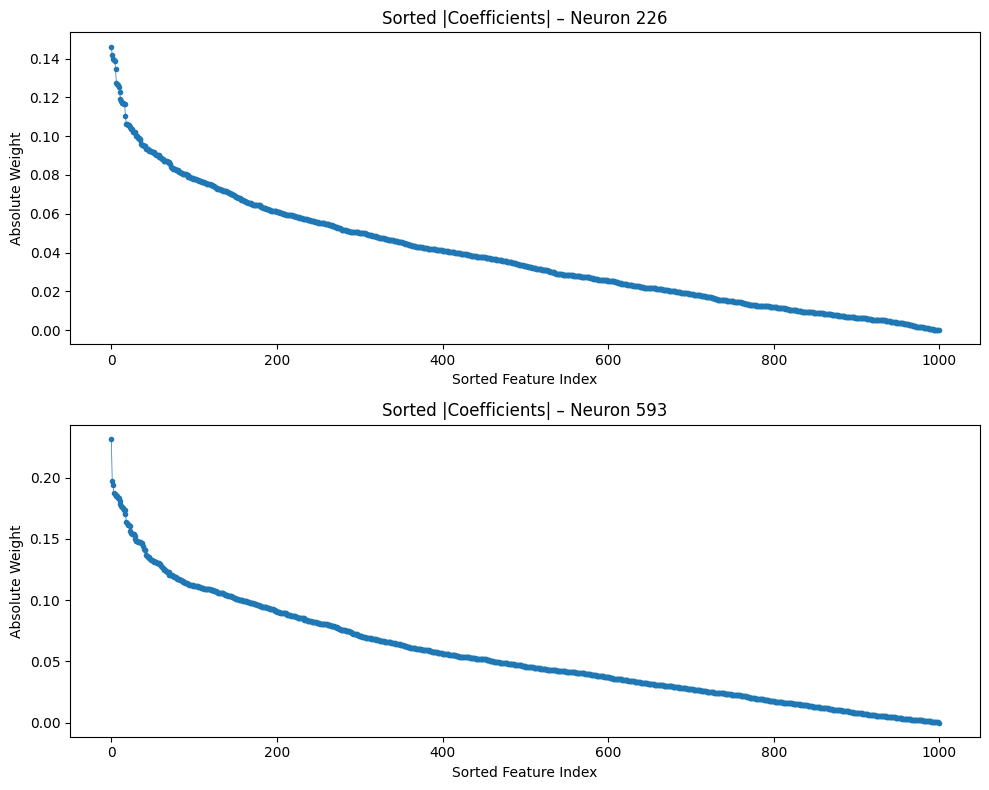

In [16]:
# ─── Plot Sorted Coefficient Magnitudes ──────────────────────────────────────
fig, axs = plt.subplots(len(selected_neurons), 1, figsize=(10, 4 * len(selected_neurons)))

if len(selected_neurons) == 1:
    axs = [axs]

for ax, neuron_idx in zip(axs, selected_neurons):
    w = coeffs[neuron_idx]
    sorted_magnitudes = np.sort(np.abs(w))[::-1]
    ax.plot(sorted_magnitudes, marker='.', linestyle='-', linewidth=0.5)
    ax.set_title(f"Sorted |Coefficients| – Neuron {neuron_idx}")
    ax.set_ylabel("Absolute Weight")
    ax.set_xlabel("Sorted Feature Index")

plt.tight_layout()
plt.show()


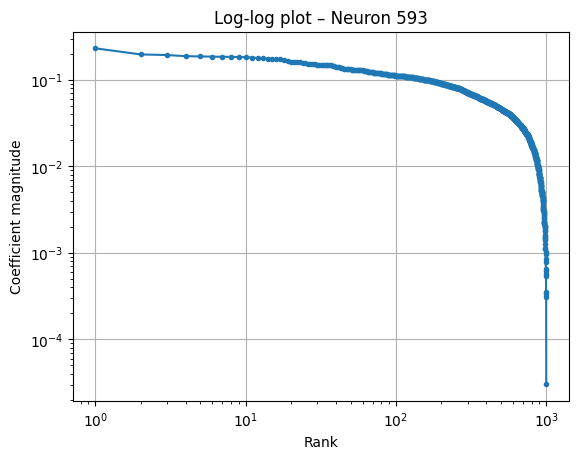

In [17]:
import matplotlib.pyplot as plt

sorted_ = np.sort(np.abs(coeffs[593]))[::-1]
plt.figure()
plt.loglog(np.arange(1, len(sorted_) + 1), sorted_, marker='.')
plt.xlabel("Rank")
plt.ylabel("Coefficient magnitude")
plt.title("Log-log plot – Neuron 593")
plt.grid(True)
plt.show()


In [19]:
import json
import urllib.request

# Load class mapping from HuggingFace
url = "https://huggingface.co/google/vit-base-patch16-224/resolve/main/config.json"
with urllib.request.urlopen(url) as f:
    config = json.load(f)
id2label = {int(k): v for k, v in config['id2label'].items()}

def print_top_classes(beta_vector, neuron_id, id2label, top_k=20):
    sorted_indices = np.argsort(beta_vector)[::-1]  # descending
    print(f"\nTop {top_k} positively weighted classes for Neuron {neuron_id}:")
    for rank in range(top_k):
        idx = sorted_indices[rank]
        label = id2label.get(idx, f"Class {idx}")
        weight = beta_vector[idx]
        print(f"{rank+1:2d}. {label:50s} | Weight: {weight:.4f}")
    
    print(f"\nTop {top_k} negatively weighted classes for Neuron {neuron_id}:")
    for rank in range(top_k):
        idx = sorted_indices[-(rank+1)]
        label = id2label.get(idx, f"Class {idx}")
        weight = beta_vector[idx]
        print(f"{rank+1:2d}. {label:50s} | Weight: {weight:.4f}")


In [20]:
print_top_classes(coeffs[226], neuron_id=226, id2label=id2label)
print_top_classes(coeffs[593], neuron_id=593, id2label=id2label)


Top 20 positively weighted classes for Neuron 226:
 1. German short-haired pointer                        | Weight: 0.1463
 2. African grey, African gray, Psittacus erithacus    | Weight: 0.1417
 3. brown bear, bruin, Ursus arctos                    | Weight: 0.1397
 4. washer, automatic washer, washing machine          | Weight: 0.1388
 5. meat loaf, meatloaf                                | Weight: 0.1256
 6. diaper, nappy, napkin                              | Weight: 0.1226
 7. Petri dish                                         | Weight: 0.1190
 8. maillot                                            | Weight: 0.1181
 9. tick                                               | Weight: 0.1171
10. unicycle, monocycle                                | Weight: 0.1165
11. harvestman, daddy longlegs, Phalangium opilio      | Weight: 0.1049
12. soup bowl                                          | Weight: 0.1045
13. whippet                                            | Weight: 0.1038
14. waffle i